In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
# ! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

In [3]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

/tmp/ipykernel_1695297/764414799.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r')
/tmp/ipykernel_1695297/764414799.py:10: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


## Dirs

In [5]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "gallant-cherry-87"

## Inference results

In [6]:
import sys
sys.path.append("../")

from datasets import get_nbody_data
x, _, conditioning, norm_dict = get_nbody_data(n_features=7, n_particles=5000, split="test")

## Load cluster run

In [7]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [8]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        64,
        config.seed,
        shuffle=True,
        split="test",
        #**config.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [9]:
config.data

add_augmentations: true
add_rotations: true
add_translations: true
box_size: 1000.0
dataset: nbody
kwargs: {}
n_features: 3
n_particles: 5000
n_pos_features: 3
simulation_set: lhc

In [10]:
config.training

batch_size: 16
eval_every_steps: 5000
half_precision: false
log_every_steps: 100
n_train_steps: 301000
p_uncond: 0.0
save_every_steps: 5000
unconditional_dropout: false
warmup_steps: 5000

In [11]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [12]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size #if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [13]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        # noise_schedule="linear",
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 637,373


In [14]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [20]:
x = x * norm_dict['std'] + norm_dict['mean']

In [21]:
n_samples = 4
step = max(1, len(conditioning) // n_samples)

idx_rnd = np.argsort(conditioning[:, 0])[::step][:n_samples]

In [22]:
# idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = [generate(vdm, restored_state.params, rng, (1, config.data.n_particles), conditioning=cond_gen[ii][None, ...], mask=mask_gen[ii][None, ...], steps=1000).mean() for ii in range(n_samples)]

In [23]:
x_samples = np.array(x_samples)
x_samples = x_samples[:, 0, ...]
x_samples = x_samples * norm_dict['std'] + norm_dict['mean']

In [24]:
# Sort by increasing Om
idx_sorted = np.argsort(conditioning[idx_rnd][:, 0])

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), subplot_kw={'projection':'3d'})

for idx in idx_sorted:
    
    idx_x = idx_rnd[idx]
    
    color = "firebrick"
    
    
    axs[0, idx].scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], 
                alpha=0.2, color=color,
                s=1, rasterized=True)

    axs[1, idx].scatter(x[idx_x, :, 0], x[idx_x, :, 1], x[idx_x, :, 2], 
                alpha=0.2, color=color,
                s=1, rasterized=True)

# ax1.set_title(r"\textbf{Generated box}", fontsize=28, rotation=36, y=0.77, x=0.22)
# ax2.set_title(r"\textbf{Simulated box}", fontsize=28, rotation=36, y=0.77, x=0.22)

lims = np.array([-20, 1020])

idx = 0

for axss in axs:
    for ax in axss:
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_zlim(lims)
    
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
    
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
    
        ax.set_axis_off()
    
        box_color = 'k'
        box_ls = '--'
        box_alpha = 0.4
        box_lw = 0.6
        
        r = np.array([0, 1000])
        X, Y = np.meshgrid(r, r)
        Z = np.array(r)
        
        # Re-creating the 2D arrays for Z component to match the shape of X and Y for the top and bottom surfaces
        Z_bottom = np.zeros_like(X)
        Z_top = np.ones_like(X) * Z[1]
        
        # Bottom surface
        ax.plot_wireframe(X, Y, Z_bottom, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
        # Top surface
        ax.plot_wireframe(X, Y, Z_top, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
        # Sides
        ax.plot_wireframe(X, np.full_like(X, Z[0]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
        ax.plot_wireframe(X, np.full_like(X, Z[1]), Y, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
        ax.plot_wireframe(np.full_like(Y, Z[0]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)
        ax.plot_wireframe(np.full_like(Y, Z[1]), Y, X, alpha=box_alpha, lw=box_lw, color=box_color, ls=box_ls)

        ax.text(0, 2000, 400, f"$\Omega_m = {conditioning[idx_rnd[idx_sorted][idx % 4]][0]:.2f},\,\sigma_8 = {conditioning[idx_rnd[idx_sorted][idx % 4]][1]:.2f}$", (0,-1, 0.75), fontsize=16,
               horizontalalignment='center', verticalalignment='center')

        idx += 1
        
axs[0, 0].text(-1000, 1250, -50, r"\textbf{Generated}", (0,1,0), fontsize=22)
axs[1, 0].text(-1000, 1250, -50, r"\textbf{Simulated}", (0,1,0), fontsize=22)

plt.tight_layout()
plt.savefig("plots/box_pos_viz.pdf", dpi=600)

## Diffusion process plot

In [15]:
from models.diffusion_utils import gamma, sigma2
import diffrax as dfx

In [16]:
def single_sample_fn(vdm, params, conditioning, mask, data_shape, dt0, t1, t0, key):


    def int_beta(t):
        return np.log(1 + np.exp(-vdm.apply(params, t, method=vdm.gammat)))    
    
    def beta(t):
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return beta

    @jax.jit
    def drift(t, y, args):

        y = y[None, ...]
        t = np.atleast_1d(t)

        beta_t = beta(t)
        g_t = vdm.apply(params, t, method=vdm.gammat)
        sigma2_t = sigma2(g_t)
        
        f = -0.5 * beta_t * y 
        g2 = beta_t
                
        eps = vdm.apply(params, y, g_t, conditioning[None, ...], mask[None, ...], method=vdm.score_eval)
        
        score = -eps / np.sqrt(sigma2_t)
        return (f - 0.5 * g2 * score)[0]

    term = dfx.ODETerm(drift)
    solver = dfx.Heun()
    y1 = jax.random.normal(key, data_shape)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

dt = 1e-2
key = jax.random.PRNGKey(4)
T = 0.1
t0 = 0.

x_single_sample = single_sample_fn(vdm, restored_state.params, conditioning[0], mask[0], (5000, 3), dt, T, t0, key)

In [ ]:
t_ary = np.linspace(0, 1, 50)

  0%|                                                         | 0/50 [00:00<?, ?it/s]

In [23]:
def generate(vdm, params, rng, shape, conditioning=None, mask=None, steps=None, sample_substeps=None):
    """Generate samples from a VDM model."""

    if sample_substeps is None:
        sample_substeps = steps
        
    # Generate latents
    rng, spl = jax.random.split(rng)

    # If using a latent projection, use embedding size; otherwise, use feature size
    zt = jax.random.normal(spl, shape + (vdm.encdec_dict["d_embedding"] if vdm.use_encdec else vdm.d_feature,))
    if vdm.timesteps == 0:
        if steps is None:
            raise Exception("Need to specify steps argument for continuous-time VLB")
        else:
            timesteps = steps
    else:
        timesteps = vdm.timesteps

    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, timesteps, z_t, conditioning, mask=mask, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=sample_substeps, body_fun=body_fn, init_val=zt)

    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

In [25]:
n_samples = 1

cond_gen = conditioning[0]
mask_gen = mask[0]

t_ary = np.linspace(0, 1, 50)

x_sample_seq_sde = [generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), 
                           conditioning=cond_gen[None, ...], mask=mask_gen[None, ...], steps=1000, sample_substeps=int(t0 * 1000)).mean()[0] for t0 in tqdm(t_ary)]

100%|████████████████████████████████████████████████| 50/50 [10:50<00:00, 13.01s/it]


In [26]:
x_sample_seq_sde = np.array(x_sample_seq_sde)
x_sample_seq_sde = x_sample_seq_sde * norm_dict['std'] + norm_dict['mean']

In [27]:
x_sample_seq_ptcl = vnp.zeros((50, 5000, 3))

delta_x = np.array([0, 200, 0])

for i in range(50):
    x_sample_seq_ptcl[i] = (x_sample_seq_sde[i, :, :] + delta_x * i)[None, :]

In [28]:
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

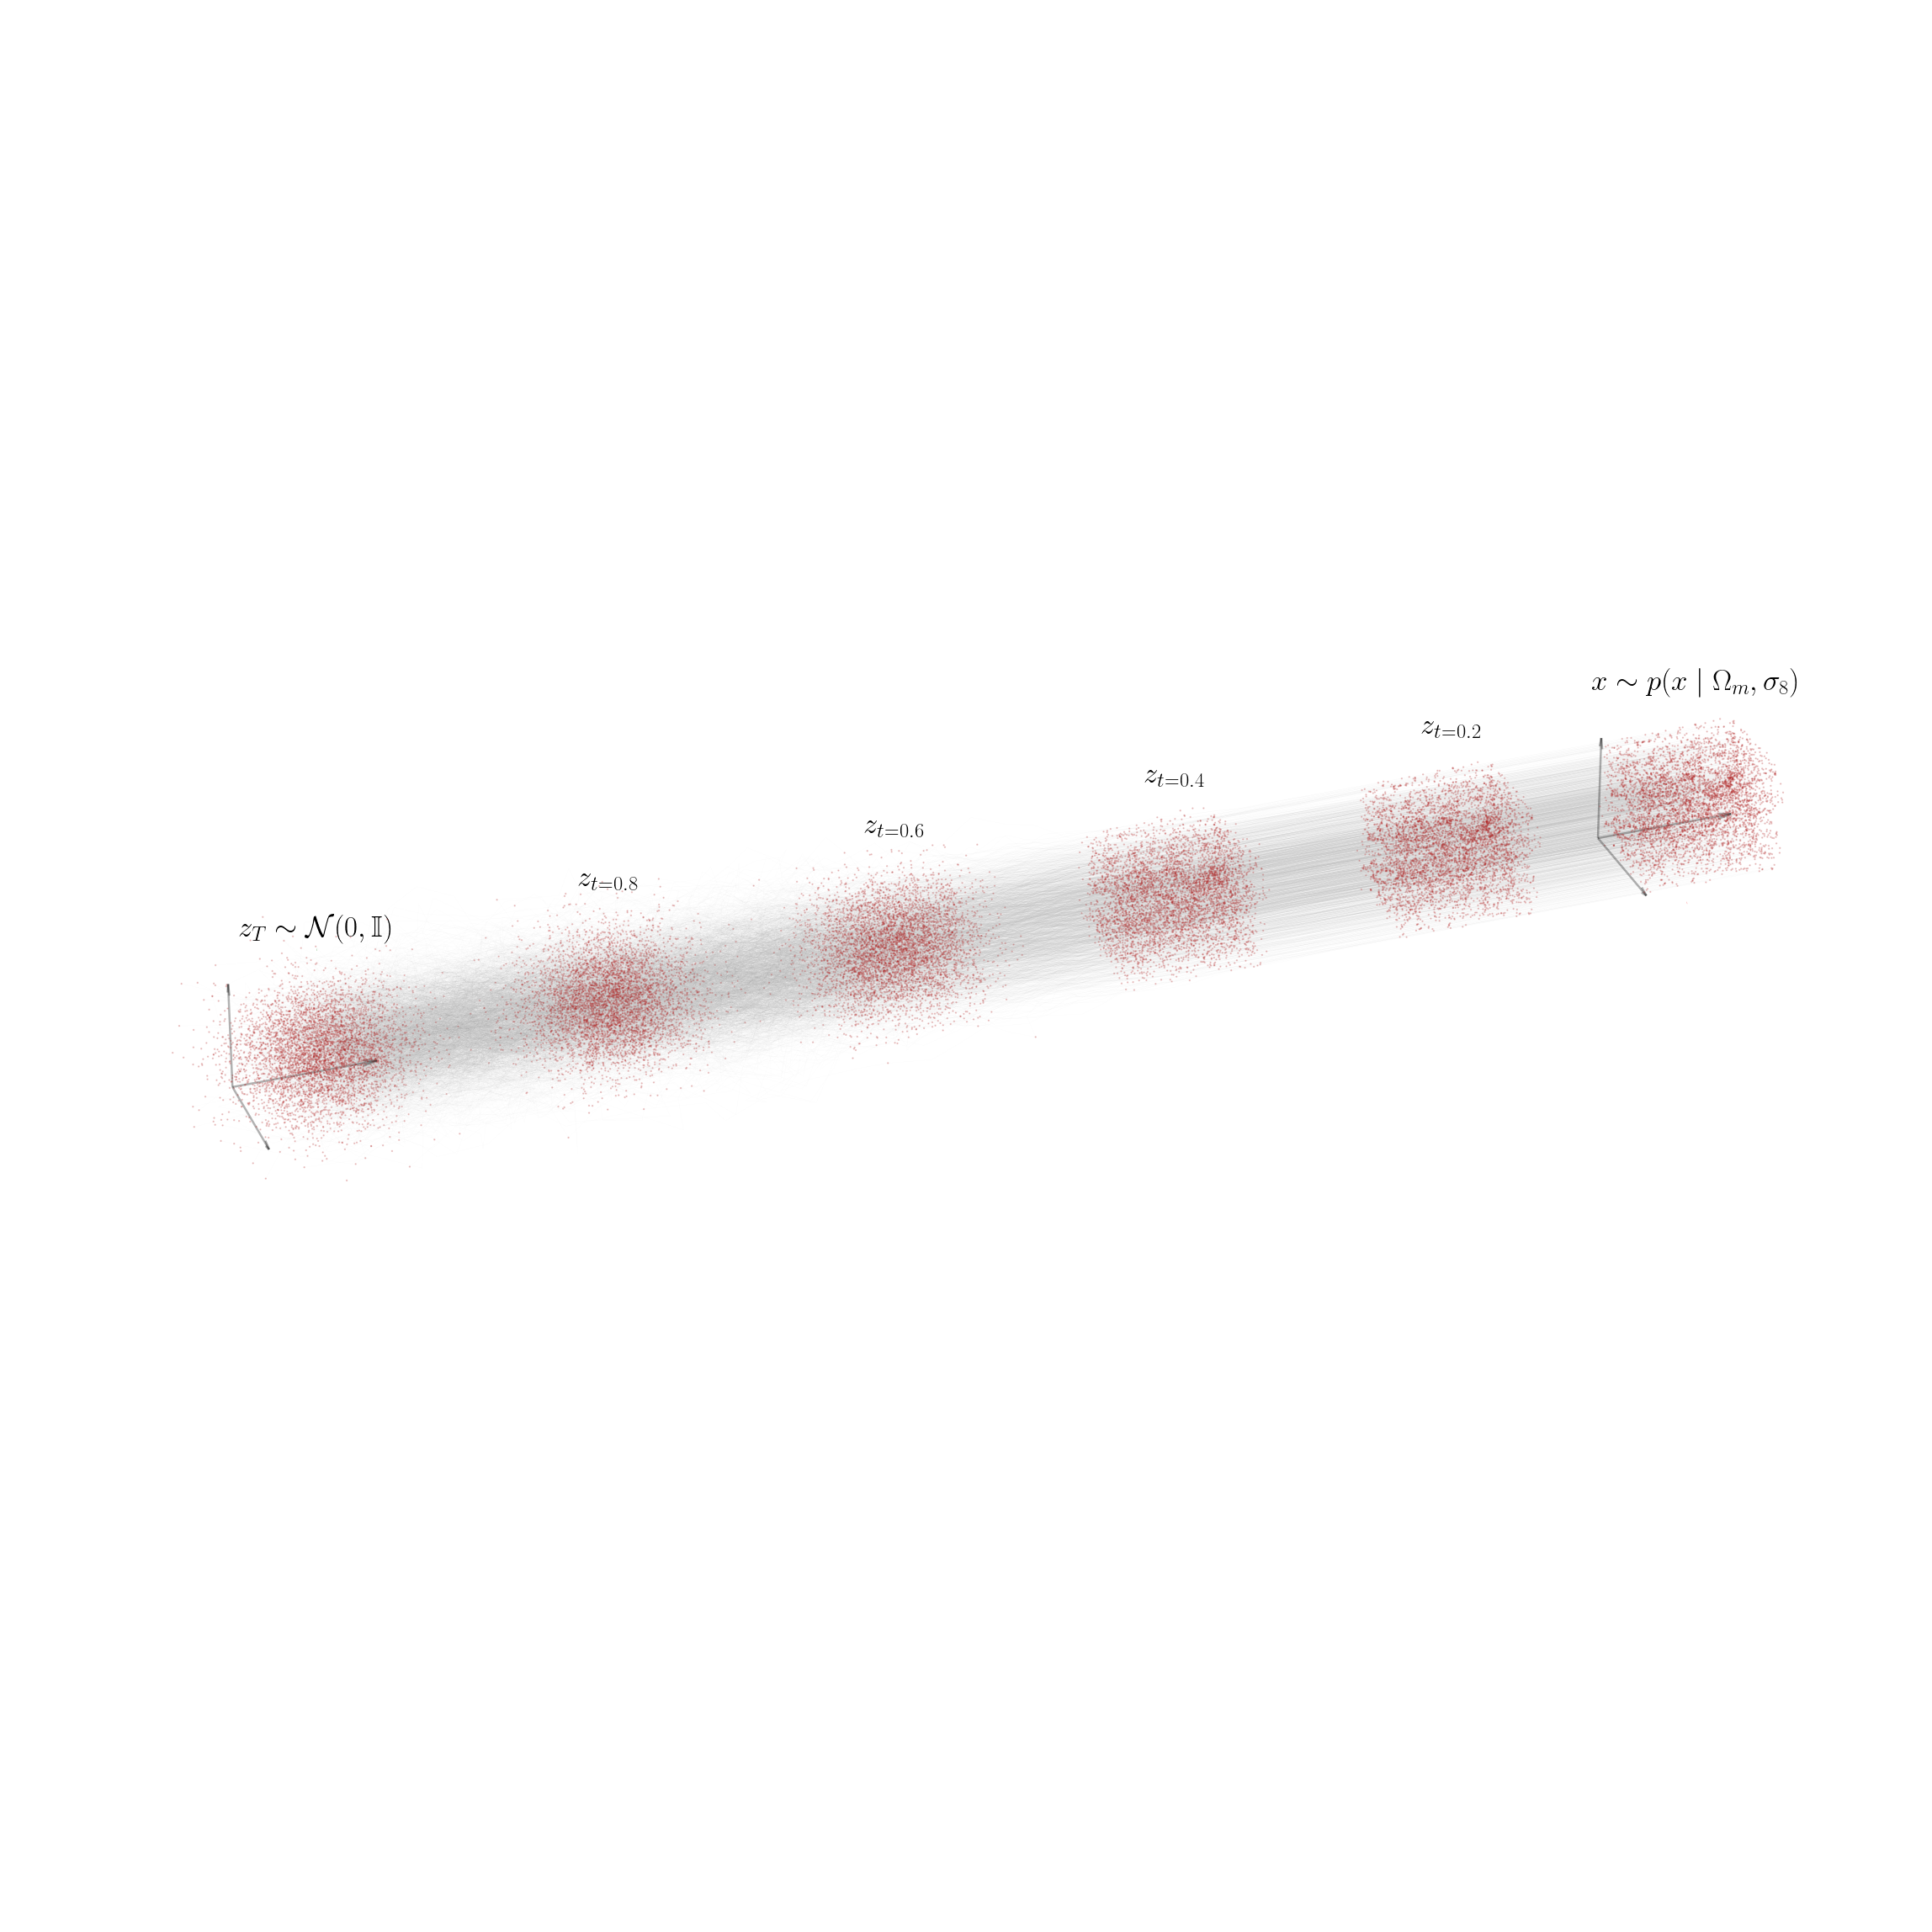

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(32, 32), subplot_kw={'projection':'3d'})
ax.view_init(30, -20)

for idx, i in enumerate(list(np.arange(0, 50, 10)) + [49]):

    ax.scatter(x_sample_seq_ptcl[i][:, 0], x_sample_seq_ptcl[i][:, 1], x_sample_seq_ptcl[i][:, 2], 
                alpha=0.2, color='firebrick', s=1.8, rasterized=True)

    # Calculate centroid of the current point cloud
    centroid_x = np.mean(x_sample_seq_ptcl[i][:, 0])
    centroid_y = np.mean(x_sample_seq_ptcl[i][:, 1])
    centroid_z = np.mean(x_sample_seq_ptcl[i][:, 2])

    # Add text annotation
    tt = t_ary[i]

    if i not in [0, 49]:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$z_{{t={(1 - tt):.1f}}}$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')

    if i == 0:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$z_T \sim \mathcal N(0, \mathbb I)$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')
    if i == 49:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$x \sim p(x\mid \Omega_m, \sigma_8)$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')

for i in range(2500):
    
    # Extract the point across all point clouds
    x = x_sample_seq_ptcl[:, i, 0]
    y = x_sample_seq_ptcl[:, i, 1]
    z = x_sample_seq_ptcl[:, i, 2]

    # Plot the line connecting these points
    ax.plot(x, y, z, lw=0.1, alpha=0.1, color='grey', rasterized=True)


ax.set_axis_off()

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

ax.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='k', alpha=0.3)

last_cloud_offset = delta_x * (50 - 1)
xx, yy, zz = last_cloud_offset

ax.quiver(xx, yy, zz, uu, vv, ww, arrow_length_ratio=0.1, color='k', alpha=0.3)

# Calculate the top points for the leftmost and rightmost point clouds
leftmost_top = np.mean(x_sample_seq_ptcl[0], axis=0) + np.array([0, 0, 1000])
rightmost_top = np.mean(x_sample_seq_ptcl[-1], axis=0) + np.array([0, 0, 1000])

# Calculate the bottom points for the leftmost and rightmost point clouds
leftmost_bottom = np.mean(x_sample_seq_ptcl[0], axis=0) - np.array([0, 0, 1000])
rightmost_bottom = np.mean(x_sample_seq_ptcl[-1], axis=0) - np.array([0, 0, 1000])

# Arrow from left to right at the top
ax.quiver(leftmost_top[0], leftmost_top[1], leftmost_top[2], 
          rightmost_top[0] - leftmost_top[0], rightmost_top[1] - leftmost_top[1], rightmost_top[2] - leftmost_top[2], 
          color='green', arrow_length_ratio=0.1, normalize=True)

# Arrow from right to left at the bottom
ax.quiver(rightmost_bottom[0], rightmost_bottom[1], rightmost_bottom[2], 
          leftmost_bottom[0] - rightmost_bottom[0], leftmost_bottom[1] - rightmost_bottom[1], leftmost_bottom[2] - rightmost_bottom[2], 
          color='red', arrow_length_ratio=0.1, normalize=True)

# ax.set_box_aspect((1, 8, 1))  # for the ODE
ax.set_box_aspect((1, 5.7, 1))  # for the SDE

plt.tight_layout()
plt.savefig("plots/diff_viz_sde_rast.pdf", dpi=300)

In [19]:
t_ary = np.linspace(0, 1, 50)
x_sample_seq_1 = [single_sample_fn(vdm, restored_state.params, np.array([0.13, 0.7]), mask[0], (5000, 3), dt, T, t0, key) for T in tqdm(t_ary)]
x_sample_seq_2 = [single_sample_fn(vdm, restored_state.params, np.array([0.47, 0.7]), mask[0], (5000, 3), dt, T, t0, key) for T in tqdm(t_ary)]

100%|████████████████████████████████████████████| 50/50 [04:21<00:00,  5.23s/it]


In [21]:
x_sample_seq_1 = np.array(x_sample_seq_1)
x_sample_seq_1 = x_sample_seq_1 * norm_dict['std'] + norm_dict['mean']

x_sample_seq_ptcl_1 = vnp.zeros((50, 5000, 3))

delta_x = np.array([0, 200, 0])

for i in range(50):
    x_sample_seq_ptcl_1[i] = (x_sample_seq_1[i, :, :] + delta_x * i)[None, :]

In [22]:
x_sample_seq_2 = np.array(x_sample_seq_2)
x_sample_seq_2 = x_sample_seq_2 * norm_dict['std'] + norm_dict['mean']

x_sample_seq_ptcl_2 = vnp.zeros((50, 5000, 3))

delta_x = np.array([0, 200, 0])

for i in range(50):
    x_sample_seq_ptcl_2[i] = (x_sample_seq_2[i, :, :] + delta_x * i)[None, :]

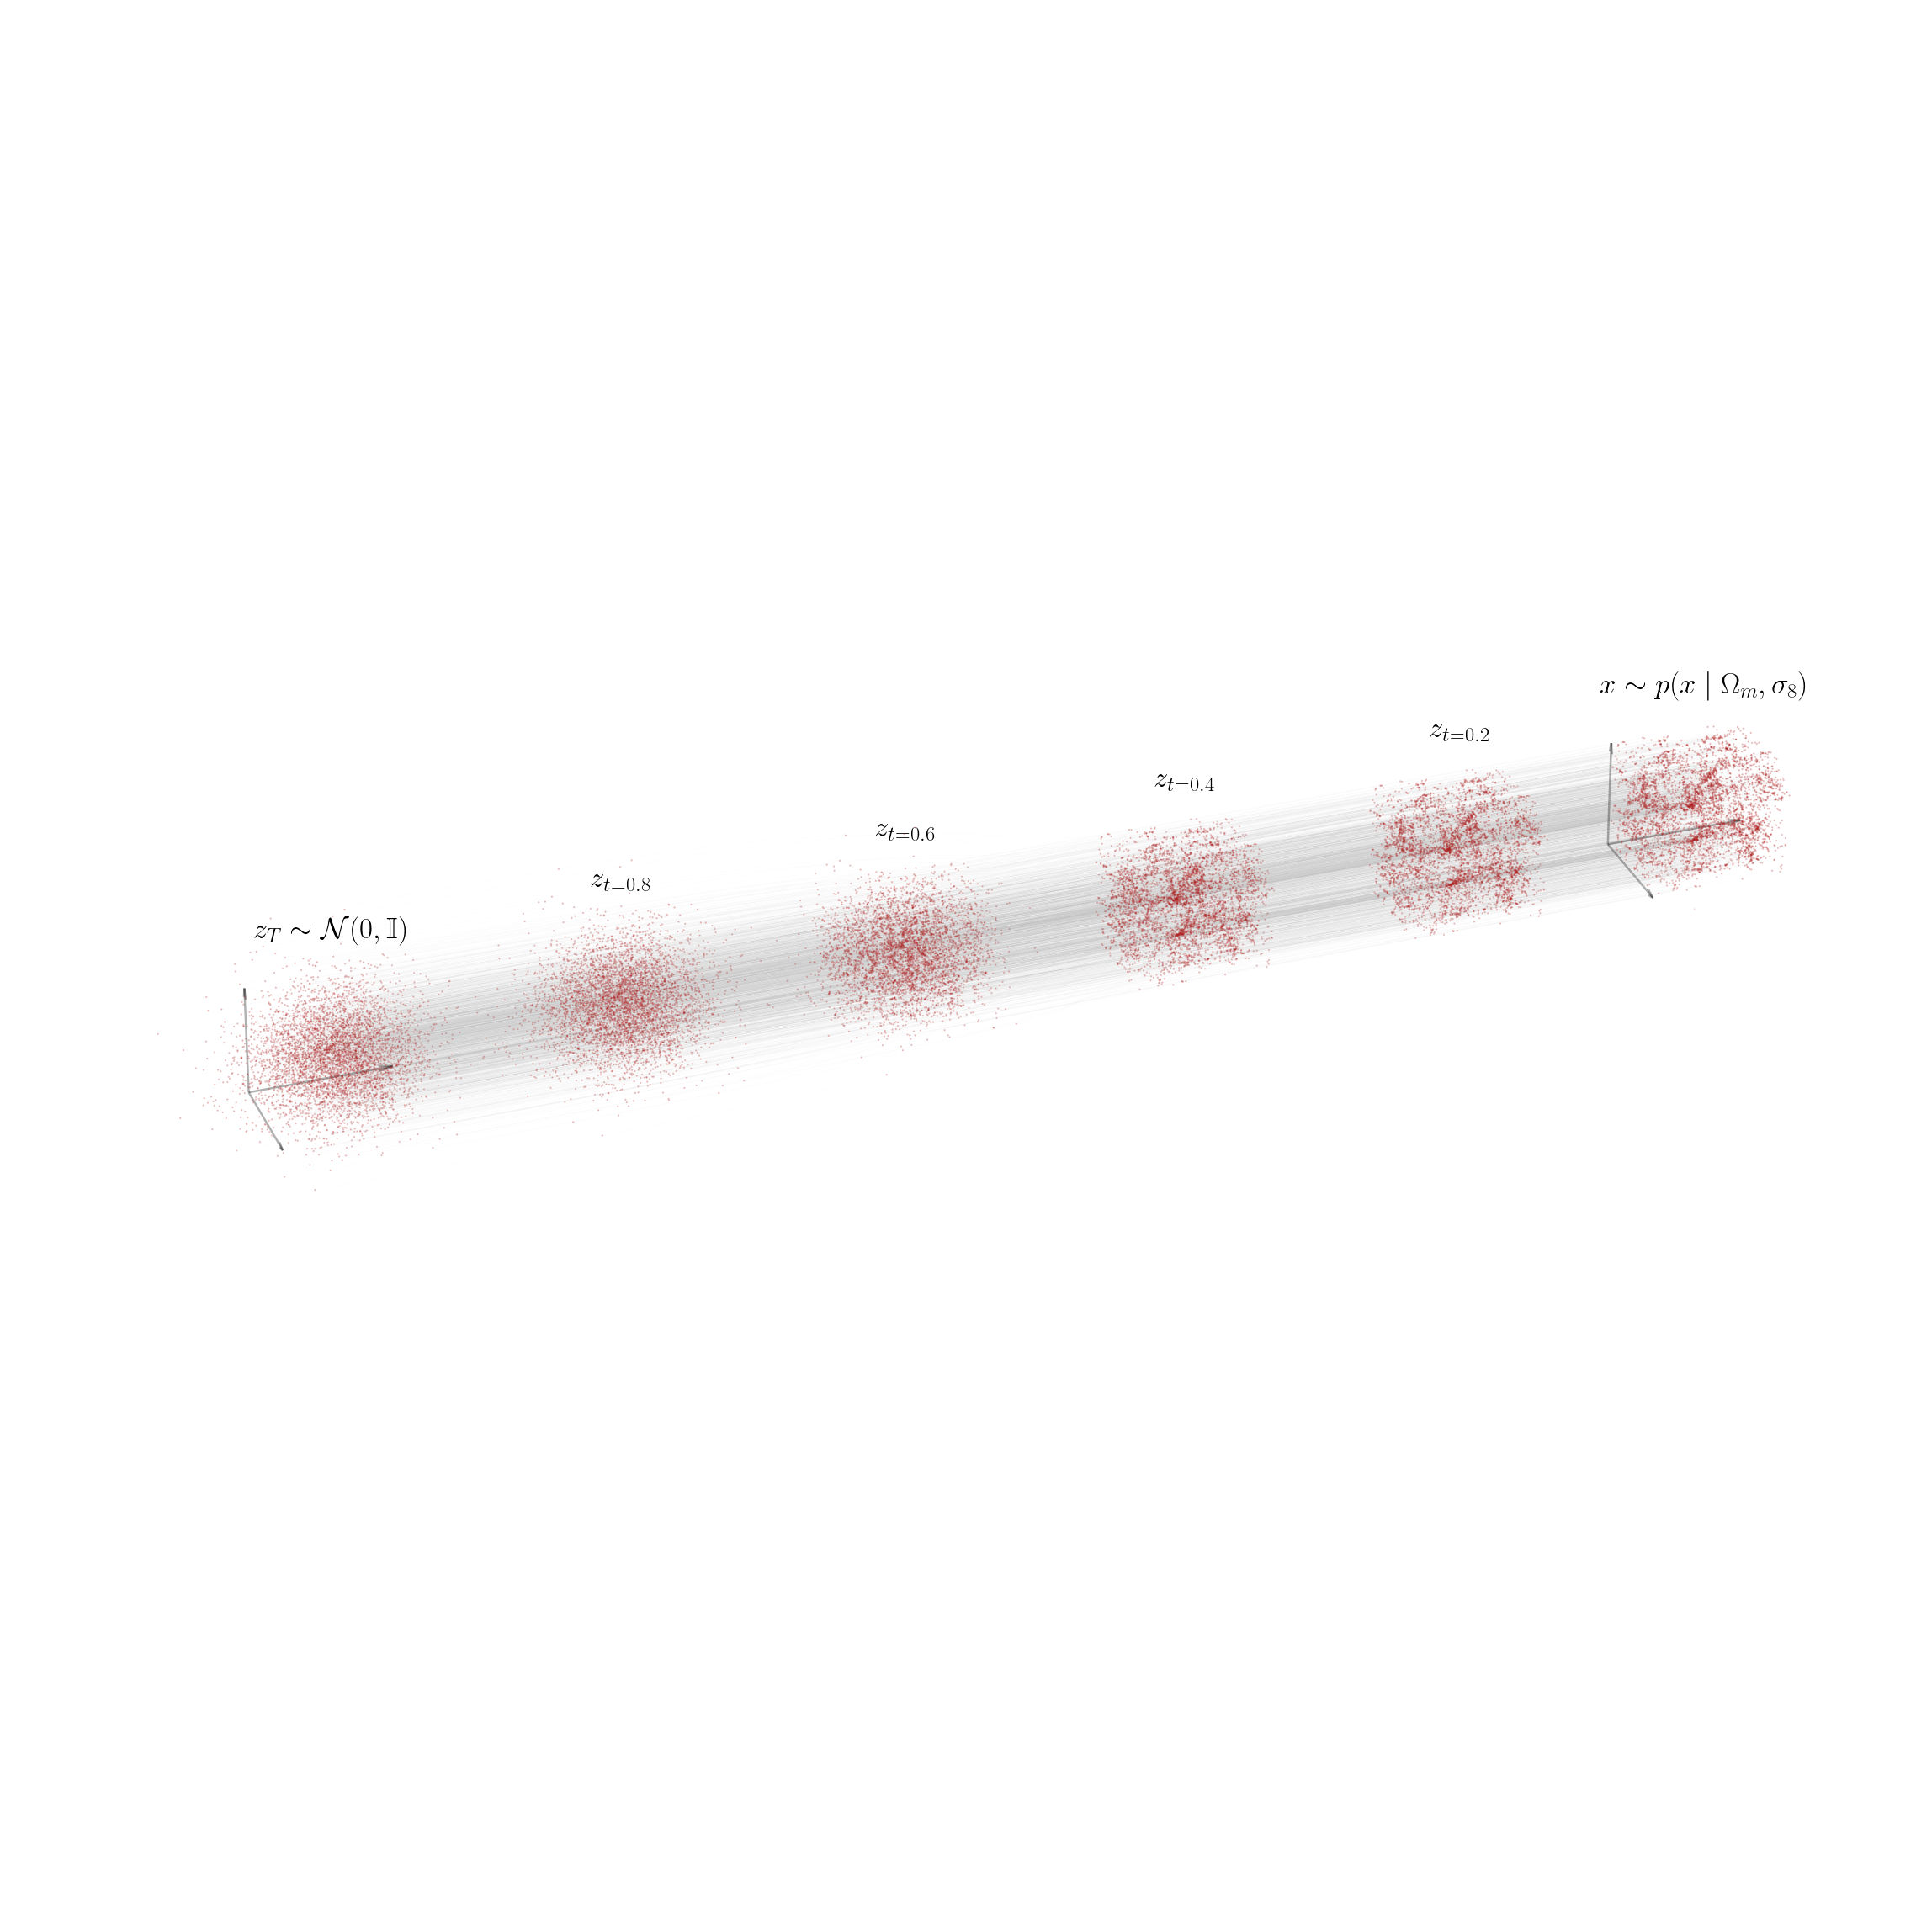

In [41]:
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, ax = plt.subplots(1, 1, figsize=(32, 32), subplot_kw={'projection':'3d'})
ax.view_init(30, -20)

for idx, i in enumerate(list(np.arange(0, 50, 10)) + [49]):

    ax.scatter(x_sample_seq_ptcl_1[i][:, 0], x_sample_seq_ptcl_1[i][:, 1], x_sample_seq_ptcl_1[i][:, 2], 
                alpha=0.2, color='firebrick', s=1.8, rasterized=True)

    # Calculate centroid of the current point cloud
    centroid_x = np.mean(x_sample_seq_ptcl_1[i][:, 0])
    centroid_y = np.mean(x_sample_seq_ptcl_1[i][:, 1])
    centroid_z = np.mean(x_sample_seq_ptcl_1[i][:, 2])

    # Add text annotation
    tt = t_ary[i]

    if i not in [0, 49]:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$z_{{t={(1 - tt):.1f}}}$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')

    if i == 0:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$z_T \sim \mathcal N(0, \mathbb I)$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')
    if i == 49:
        ax.text(centroid_x, centroid_y, centroid_z + 1200, f"$x \sim p(x\mid \Omega_m, \sigma_8)$", color='k', fontsize=35,
            horizontalalignment='center', verticalalignment='center')

for i in range(2500):
    
    # Extract the point across all point clouds
    x = x_sample_seq_ptcl_1[:, i, 0]
    y = x_sample_seq_ptcl_1[:, i, 1]
    z = x_sample_seq_ptcl_1[:, i, 2]

    # Plot the line connecting these points
    ax.plot(x, y, z, lw=0.1, alpha=0.1, color='grey', rasterized=True)

# for i in range(2500):
    
#     # Extract the point across all point clouds
#     x = x_sample_seq_ptcl_2[:, i, 0]
#     y = x_sample_seq_ptcl_2[:, i, 1]
#     z = x_sample_seq_ptcl_2[:, i, 2]

#     # Plot the line connecting these points
#     ax.plot(x, y, z, lw=0.05, alpha=0.1, color=cols_default[1], rasterized=True)


ax.set_axis_off()

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

ax.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='k', alpha=0.3)

last_cloud_offset = delta_x * (50 - 1)
xx, yy, zz = last_cloud_offset

ax.quiver(xx, yy, zz, uu, vv, ww, arrow_length_ratio=0.1, color='k', alpha=0.3)

# Calculate the top points for the leftmost and rightmost point clouds
leftmost_top = np.mean(x_sample_seq_ptcl_1[0], axis=0) + np.array([0, 0, 1000])
rightmost_top = np.mean(x_sample_seq_ptcl_1[-1], axis=0) + np.array([0, 0, 1000])

# Calculate the bottom points for the leftmost and rightmost point clouds
leftmost_bottom = np.mean(x_sample_seq_ptcl_1[0], axis=0) - np.array([0, 0, 1000])
rightmost_bottom = np.mean(x_sample_seq_ptcl_1[-1], axis=0) - np.array([0, 0, 1000])

# Arrow from left to right at the top
ax.quiver(leftmost_top[0], leftmost_top[1], leftmost_top[2], 
          rightmost_top[0] - leftmost_top[0], rightmost_top[1] - leftmost_top[1], rightmost_top[2] - leftmost_top[2], 
          color='green', arrow_length_ratio=0.1, normalize=True)

# Arrow from right to left at the bottom
ax.quiver(rightmost_bottom[0], rightmost_bottom[1], rightmost_bottom[2], 
          leftmost_bottom[0] - rightmost_bottom[0], leftmost_bottom[1] - rightmost_bottom[1], leftmost_bottom[2] - rightmost_bottom[2], 
          color='red', arrow_length_ratio=0.1, normalize=True)

ax.set_box_aspect((1, 7, 1))  # for the ODE
# ax.set_box_aspect((1, 5.7, 1))  # for the SDE

plt.tight_layout()
plt.savefig("plots/diff_viz_ode.pdf", dpi=300)